# Different kinds of MRI data preprocessing
****************

**<div itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-5567-801X" href="https://orcid.org/0000-0001-5567-801X" target="orcid.widget" rel="me noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-left:0em;"  alt="ORCID iD icon">Adrián Arnaiz-Rodríguez</a></div>**

**This notebook is a deeper introduction to Medical Image treatment**

**We put in discussion the most importants kinds of preprocessing:  for both image information recovery and image transformation**

**In futher stages we will apply some of that transformations to data-preprocessing stage and data exploration**

**For example, before we send the images to the autoencoder, we could:**
* Equalizate with CDF or other contrast enhancements to improve difference between parts.
* Noramlize voxel values.
* Maybe we could get a mask to detect the brain and then select only the slices which distance is bigger than some value.
* Translate to mass center and rotate every iamge to same position.
* Downsampling for faster trainning
* Add Gaussian noise to data augmentation
* Inpainting and crop for Data augm

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Image-Shape,-Sampling-Shape,-Field-of-view-and-volume" data-toc-modified-id="Image-Shape,-Sampling-Shape,-Field-of-view-and-volume-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Image Shape, Sampling Shape, Field of view and volume</a></span></li><li><span><a href="#Views" data-toc-modified-id="Views-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Views</a></span></li><li><span><a href="#Histogram-of-pixel-values-and-equalization" data-toc-modified-id="Histogram-of-pixel-values-and-equalization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Histogram of pixel values and equalization</a></span><ul class="toc-item"><li><span><a href="#Normalization" data-toc-modified-id="Normalization-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Normalization</a></span></li><li><span><a href="#Histogram" data-toc-modified-id="Histogram-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Histogram</a></span></li><li><span><a href="#Equalization:-Direct-value-[0-255]" data-toc-modified-id="Equalization:-Direct-value-[0-255]-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Equalization: Direct value [0-255]</a></span></li><li><span><a href="#Equalization:--Cumulative-distribution-function" data-toc-modified-id="Equalization:--Cumulative-distribution-function-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Equalization:  Cumulative distribution function</a></span></li><li><span><a href="#Enhance-Contrast" data-toc-modified-id="Enhance-Contrast-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Enhance Contrast</a></span></li></ul></li><li><span><a href="#Masks" data-toc-modified-id="Masks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Masks</a></span><ul class="toc-item"><li><span><a href="#Mask4Crop" data-toc-modified-id="Mask4Crop-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Mask4Crop</a></span></li></ul></li><li><span><a href="#Filters" data-toc-modified-id="Filters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Filters</a></span><ul class="toc-item"><li><span><a href="#Smoothing---Improve-SNR---GAUSSIAN" data-toc-modified-id="Smoothing---Improve-SNR---GAUSSIAN-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Smoothing - Improve SNR - GAUSSIAN</a></span></li><li><span><a href="#RANDOM-NOISE" data-toc-modified-id="RANDOM-NOISE-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>RANDOM NOISE</a></span></li></ul></li><li><span><a href="#Measure-Intensity" data-toc-modified-id="Measure-Intensity-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Measure Intensity</a></span></li><li><span><a href="#Morphology" data-toc-modified-id="Morphology-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Morphology</a></span><ul class="toc-item"><li><span><a href="#Center-of-mass" data-toc-modified-id="Center-of-mass-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Center of mass</a></span></li></ul></li><li><span><a href="#Registration" data-toc-modified-id="Registration-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Registration</a></span><ul class="toc-item"><li><span><a href="#Translation" data-toc-modified-id="Translation-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Translation</a></span></li><li><span><a href="#Rotation" data-toc-modified-id="Rotation-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Rotation</a></span></li><li><span><a href="#Affine-Matrix---TO-BE-DONE" data-toc-modified-id="Affine-Matrix---TO-BE-DONE-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Affine Matrix - TO BE DONE</a></span></li></ul></li><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Downsampling</a></span></li><li><span><a href="#UpSampling" data-toc-modified-id="UpSampling-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>UpSampling</a></span></li></ul></div>

In [1]:
import scipy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import nibabel as nib

from skimage.filters import gaussian
from skimage import exposure
from skimage.transform import rotate, resize
from skimage.restoration import inpaint
from skimage.util import random_noise

import scipy.ndimage as ndi


np.set_printoptions(precision=4, suppress=True)
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.legend(loc='center right')
    plt.show()
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)    
    plt.title(title)
    plt.axis('off')
    plt.show()

In [3]:
files = glob.glob('../IXI-T1/*.gz')
len(files), files[0]

(581, '../IXI-T1\\IXI002-Guys-0828-T1.nii.gz')

In [4]:
volume = nib.load(files[0])

In [5]:
h = volume.header
print(h)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 150   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.      0.9375  0.9375  1.2     0.      0.      0.      0.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'MR'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.468175
quatern_c       : -0.5299171
quatern_d       : -0.468175
qoffset_x       : -88.63989
qoffset_y       : 116.532005
qoff

## Image Shape, Sampling Shape, Field of view and volume

* **Image shape**: number of elements along each axis
* **Sampling rate**: physical space covered by each element
* **Field of view**: physical space covered along each axis
* **Spatial extent**: Total physical space of the volume

In [6]:
h['dim']

array([  3, 256, 256, 150,   1,   1,   1,   1], dtype=int16)

In [7]:
# Image shape (in number of voxels)
n0, n1, n2 = h.get_data_shape()
n0, n1, n2

(256, 256, 150)

In [8]:
# Sampling rate (voexel size in mm)
d0, d1, d2 = h.get_zooms()
d0, d1, d2

(0.9375, 0.9375, 1.199997)

In [9]:
# Field of view (in mm)
n0 * d0, n1 * d1, n2 * d2

(240.0, 240.0, 179.99954223632812)

In [10]:
#Spatial extent
dvoxel = d0*d1*d2
nvoxels = n0*n1*n2
# Calculate volume
spatial_extent = nvoxels * dvoxel
spatial_extent

10367974.21875

**La imagen real mide 24 x 24 x 18 cm<sup>2</sup>**

## Views

In or dataset:
* We get coronal view with 1st dim fixed.
* We get axial view with 2nd dim fixed.
* We get sagittal view with 3rd dim fixed.

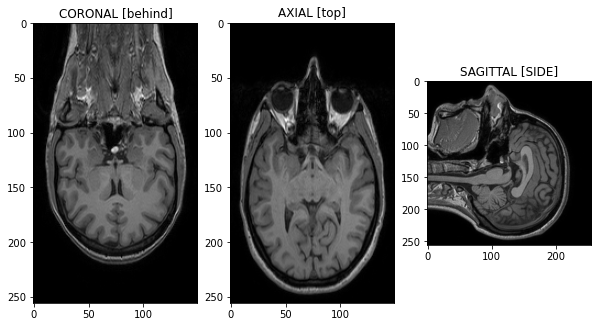

In [11]:
plt.figure(figsize=[10,10])

i_x = 127
i_y = 127
i_z = 75

slice_x = np.squeeze(volume.slicer[i_x:i_x+1,:,:].get_fdata())
slice_y = np.squeeze(volume.slicer[:,i_y:i_y+1,:].get_fdata())
slice_z = np.squeeze(volume.slicer[:,:,i_z:i_z+1].get_fdata())


plt.subplot(131)
plt.imshow(slice_x, cmap='gray')
plt.title('CORONAL [behind]')

plt.subplot(132)
plt.imshow(slice_y, cmap='gray')
plt.title('AXIAL [top]')

plt.subplot(133)
plt.imshow(slice_z, cmap='gray')
plt.title('SAGITTAL [SIDE]')

plt.show()

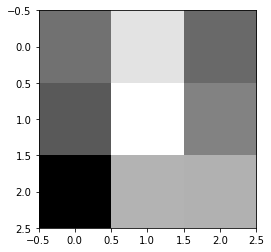

In [12]:
plt.imshow(slice_z[40:43,109:112], cmap='gray')

## Histogram of pixel values and equalization

### Normalization


In [13]:
slice_z_norm = (slice_z-slice_z.min()) / (slice_z.max()-slice_z.min())
slice_z_norm255 = (255*slice_z_norm).astype(int)
slice_z_norm.max(), slice_z_norm.min(),slice_z_norm255.max(), slice_z_norm255.min()

(1.0, 0.0, 255, 0)

**We have normalized from 0-1 and 0-255. We can see 3 histograms looks like the same**.

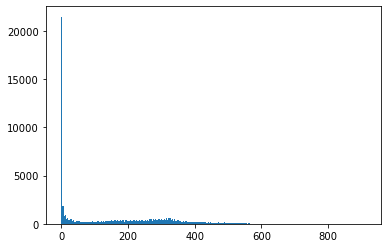

In [14]:
plt.hist(slice_z.ravel(), bins=256);

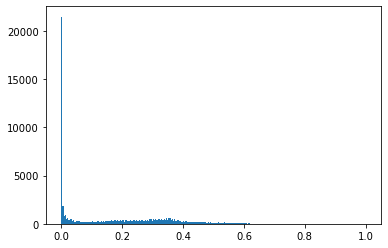

In [15]:
plt.hist(slice_z_norm.ravel(), bins=256);

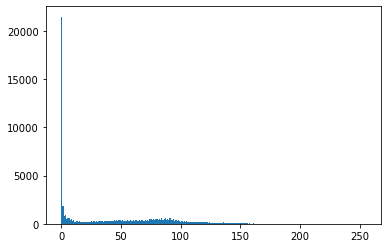

In [16]:
plt.hist(slice_z_norm255.ravel(), bins=256);

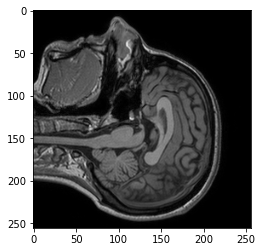

In [17]:
plt.imshow(slice_z_norm, cmap='gray')
plt.show()

### Histogram

**Histogram of escaled [0-1]**

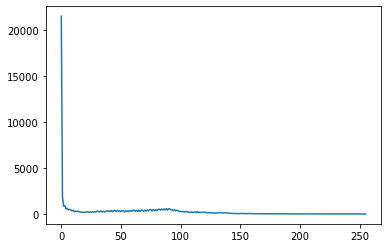

In [18]:

hist = ndi.histogram(slice_z_norm, 
                     min=0,
                     max=1,
                     bins=256)
plt.plot(hist)
plt.show()

**Histograma of original slice**

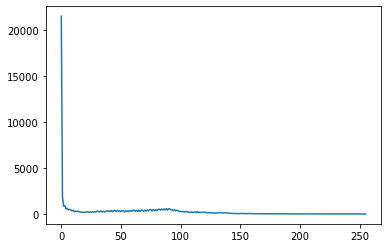

In [19]:
hist = ndi.histogram(slice_z, 
                     min=slice_z.min(),
                     max=slice_z.max(),
                     bins=256
                    )
plt.plot(hist)
plt.show()

### Equalization: Direct value [0-255]

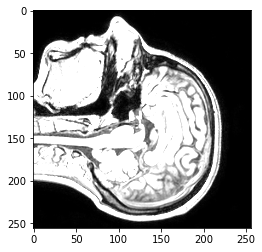

In [20]:
plt.imshow(slice_z, vmin=0, vmax=255, cmap='gray')
plt.show()

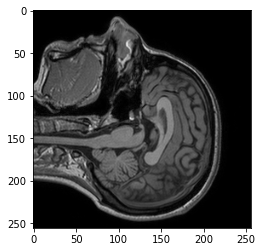

In [21]:
plt.imshow(slice_z_norm, vmin=0, vmax=1, cmap='gray')
plt.show()

### Equalization:  Cumulative distribution function

In [22]:
cdf = hist.cumsum() / hist.sum()
im_equalized = cdf[(255*slice_z_norm).astype(int)]*255

In [23]:
im_equalized_norm = (im_equalized-im_equalized.min()) / (im_equalized.max()-im_equalized.min())
im_equalized_norm255 = (255*im_equalized).astype(int)

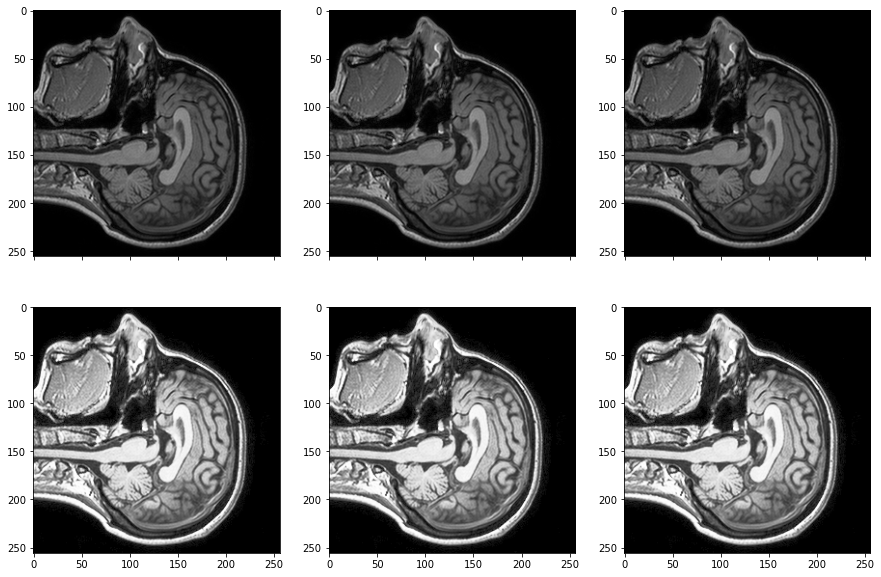

In [24]:
fig, axes = plt.subplots(2, 3, sharex=True,figsize=[15,10])

axes[0][0].imshow(slice_z, label='Original')
axes[0][1].imshow(slice_z_norm, label='oRIGINAL[0-1]')
axes[0][2].imshow(slice_z_norm255, label='oRIGINAL[0-255]')
axes[1][0].imshow(im_equalized, label='CDF')
axes[1][1].imshow(im_equalized_norm, label='CDF')
axes[1][2].imshow(im_equalized_norm255, label='CDF')
plt.show()

Original histogram an cdf

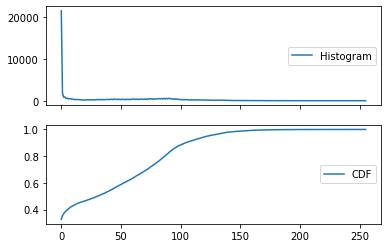

In [25]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(hist, label='Histogram')
axes[1].plot(cdf, label='CDF')
format_and_render_plot()

Image cdf histogram

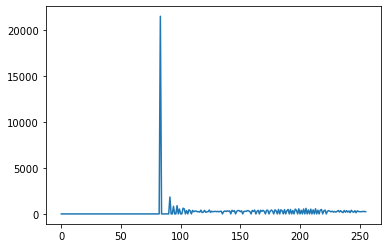

In [26]:
hist = ndi.histogram(im_equalized, 
                     min = 0,
                     max = 255,
                     bins = 256
                    )
plt.plot(hist)
plt.show()

### Enhance Contrast

**Types**:
* Histogram equalization
* Adaptive histogram equalization
* Contrast Limited Adaptive Histogram Equalization (CLAHE)

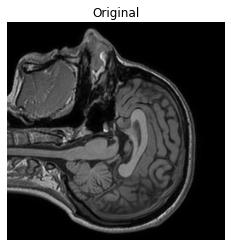

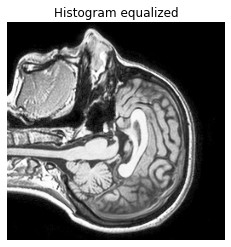

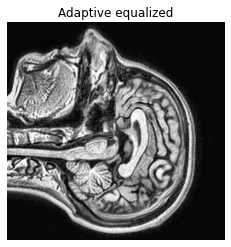

In [27]:
# Obtain the equalized images
image_eq = exposure.equalize_hist(slice_z_norm)
image_adapteq = exposure.equalize_adapthist(slice_z_norm, clip_limit=0.03)

# Show original and result
show_image(slice_z_norm, 'Original')
show_image(image_eq, 'Histogram equalized')
show_image(image_adapteq, 'Adaptive equalized')

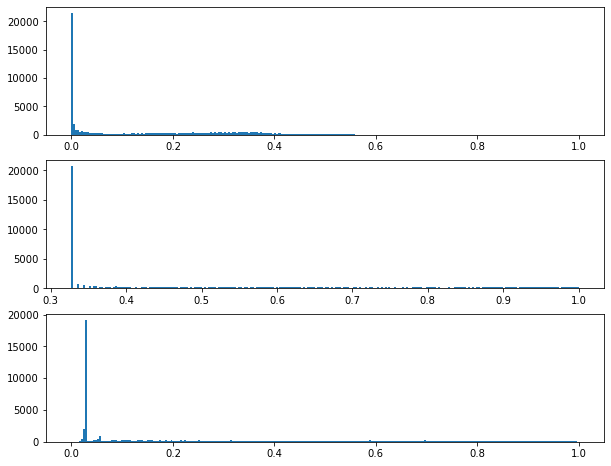

In [28]:
fig, axes = plt.subplots(3,1, figsize=[10,8])
axes[0].hist(slice_z_norm.ravel(), bins=256)
axes[1].hist(image_eq.ravel(), bins=256)
axes[2].hist(image_adapteq.ravel(), bins=256)
plt.show()

## Masks

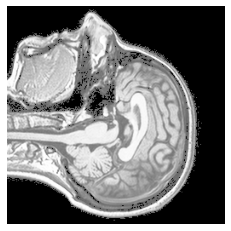

In [29]:
im_equalized_mask = np.where(im_equalized > 100, im_equalized, 0)
plt.imshow(im_equalized_mask, cmap='gray')
plt.axis('off')
plt.show()

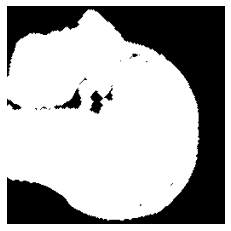

In [30]:
m = ndi.binary_erosion(im_equalized_mask,iterations=2)
m = ndi.binary_dilation(m,iterations=4)
plt.imshow(m, cmap='gray')
plt.axis('off')
plt.show()

Other approach:

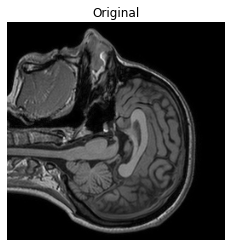

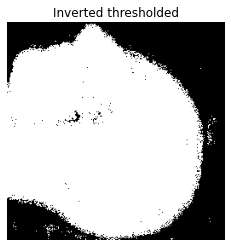

In [31]:
thresh = 1
# Apply thresholding to the image
inverted_binary = slice_z_norm255 >= thresh
# Show the original and thresholded
show_image(slice_z_norm255, 'Original')
show_image(inverted_binary, 'Inverted thresholded')

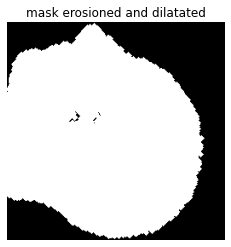

In [32]:
m = ndi.binary_dilation(ndi.binary_erosion(inverted_binary,iterations=2),iterations=3)
show_image(m, 'mask erosioned and dilatated')

### Mask4Crop

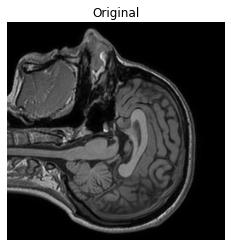

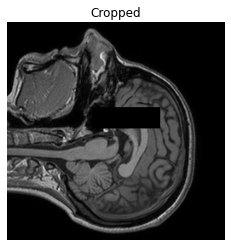

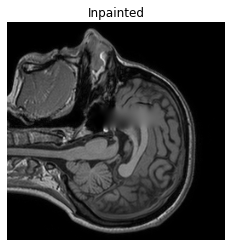

In [33]:
mask = np.zeros(slice_z_norm.shape)

# Set the pixels where the logo is to 1
mask[100:125, 100:180] = 1
slice_z_norm_cropped = slice_z_norm.copy()
slice_z_norm_cropped[100:125, 100:180] = 0

image_logo_removed = inpaint.inpaint_biharmonic(slice_z_norm, mask, multichannel=False)

# Show the original and logo removed images
show_image(slice_z_norm, 'Original')
show_image(slice_z_norm_cropped, 'Cropped')
show_image(image_logo_removed, 'Inpainted')

## Filters 

### Smoothing - Improve SNR - GAUSSIAN

Smoothing **can improve the signal-to-noise ratio** of your image by blurring out small variations in intensity. The Gaussian filter is excellent for this: it is a circular (or spherical) smoothing kernel that weights nearby pixels higher than distant ones.

The width of the distribution is controlled by the sigma argument, with higher values leading to larger smoothing effects.

In [34]:
im_s1 = ndi.gaussian_filter(im_equalized, sigma=1)
im_s3 = ndi.gaussian_filter(im_equalized, sigma=3)

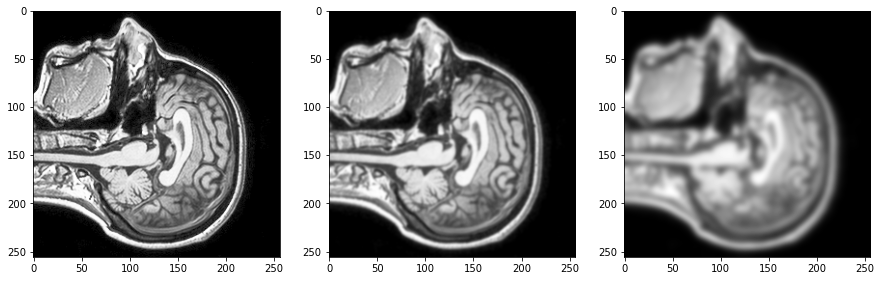

In [35]:
fig, axes = plt.subplots(1,3, figsize=[15,10])
axes[0].imshow(im_equalized)
axes[1].imshow(im_s1)
axes[2].imshow(im_s3)
plt.show()

*Other filters made another transformations*

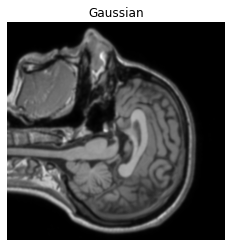

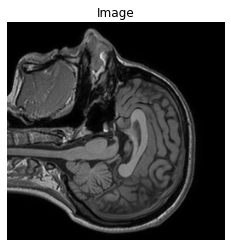

In [36]:

# Apply edge detection filter
gaussian_image = gaussian(slice_z_norm, multichannel=False)
# Show original and resulting image to compare
show_image(gaussian_image, 'Gaussian')
show_image(slice_z_norm)

### RANDOM NOISE

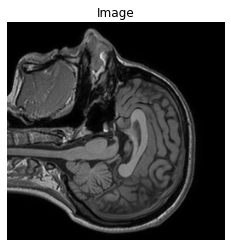

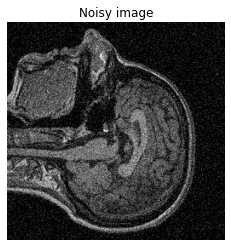

In [37]:
noisy_image = random_noise(slice_z_norm)
# Show original and resulting image
show_image(slice_z_norm)
show_image(noisy_image, 'Noisy image')

## Measure Intensity

In [38]:

np_vol = volume.get_fdata()
np_vol_norm = (((np_vol - np_vol.min()) / (np_vol.max()-np_vol.min()))*255).astype(int)

In [39]:
ndi.mean(np_vol_norm)

25.00454661051432

In [40]:
ndi.variance(np_vol_norm)

1547.394803648804

## Morphology

We can measure, for example, the width of the brain mask made in the previous step.

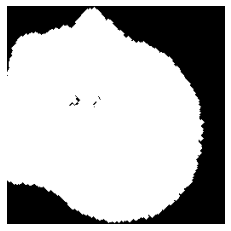

In [41]:
plt.imshow(m, cmap='gray')
plt.axis('off')
plt.show()

In terms of number of voxels

In [42]:
d=ndi.distance_transform_edt(m)
d.max()

72.00694410957877

In terms on real distance

In [43]:
d=ndi.distance_transform_edt(m, sampling=(d0,d1)) #We put fixed the d2->sagittal
d.max()

67.50651010273009

### Center of mass

In [44]:
com=ndi.center_of_mass(im_equalized)
com

(130.73325408293712, 118.38860865379111)

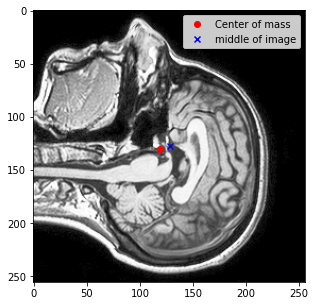

In [45]:
plt.figure(figsize=(5,5))
plt.imshow(im_equalized)
plt.scatter(com[1], com[0], color='red', label='Center of mass')
plt.scatter(256/2, 256/2, color='blue', marker='x', label='middle of image')
plt.legend(loc='best')
plt.show()

## Registration
**Goals**:

* Align images to template
* Minimize spatial variability
* Templates:
   * may represent multiple subjects
   * may be an "average" image
* Entails many spatial transformations

**Affine transformations**: preserve points, lines, and planes
* Translate
* Rotate
* Scale
* Shear

### Translation

Translate to match center of image and center of mass

In [46]:
com = ndi.center_of_mass(slice_z_norm)
d0 = slice_z_norm.shape[0]/2 - com[0]
d1 = slice_z_norm.shape[1]/2 - com[1]
xfm = ndi.shift(slice_z_norm, shift=[d0, d1])

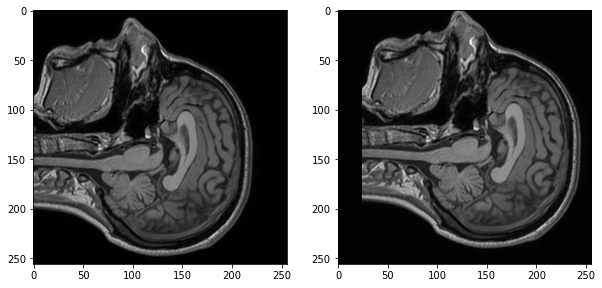

In [47]:
fig, axes = plt.subplots(1,2, figsize=[10,10])
axes[0].imshow(slice_z_norm)
axes[1].imshow(xfm)
plt.show()

### Rotation

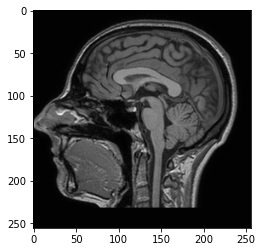

In [48]:
plt.imshow(ndi.rotate(xfm,90,reshape=False))
plt.show()

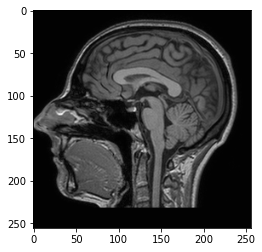

In [49]:
#skimage
plt.imshow(rotate(xfm,90))
plt.show()

### Affine Matrix - TO BE DONE

*affine* is the affine array relating array coordinates from the image data array to coordinates in some RAS+ world coordinate system.

In [50]:
h['sform_code']

array(1, dtype=int16)

In [51]:
volume.affine

array([[   0.    ,    0.    ,    1.2   ,  -88.6399],
       [  -0.9304,    0.1155,    0.    ,  116.532 ],
       [   0.1155,    0.9304,   -0.    , -112.1136],
       [   0.    ,    0.    ,    0.    ,    1.    ]])

In [52]:
volume.get_sform() 

array([[   0.    ,    0.    ,    1.2   ,  -88.6399],
       [  -0.9304,    0.1155,    0.    ,  116.532 ],
       [   0.1155,    0.9304,   -0.    , -112.1136],
       [   0.    ,    0.    ,    0.    ,    1.    ]])

## Downsampling

scipy

In [53]:
slice_z_downsampled = ndi.zoom(slice_z_norm, zoom=0.5)
slice_z_downsampled.shape

(128, 128)

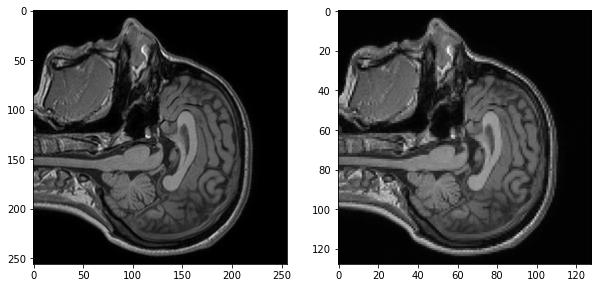

In [54]:
fig, axes = plt.subplots(1,2, figsize=[10,10])
axes[0].imshow(slice_z_norm)
axes[1].imshow(slice_z_downsampled)
plt.show()

skimage

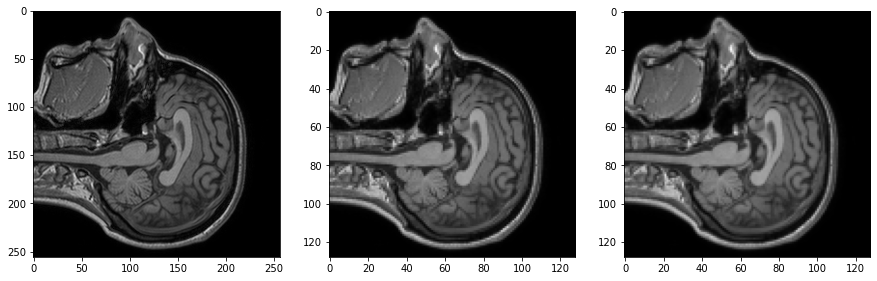

In [55]:
fig, axes = plt.subplots(1,3, figsize=[15,15])
axes[0].imshow(slice_z_norm)
axes[1].imshow(resize(slice_z_norm, (128, 128), anti_aliasing=False))
axes[2].imshow(resize(slice_z_norm, (128, 128), anti_aliasing=True))
plt.show()

## UpSampling

In [56]:
slice_z_upsampled= ndi.zoom(slice_z_norm, zoom=5, order = 0)
slice_z_upsampled4= ndi.zoom(slice_z_norm, zoom=5, order = 4)
slice_z_upsampled.shape

(1280, 1280)

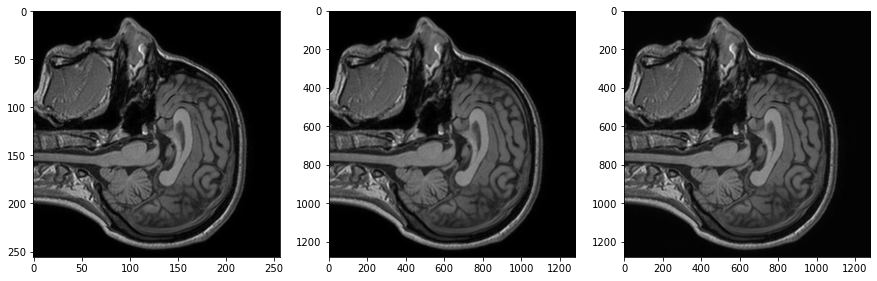

In [57]:
fig, axes = plt.subplots(1,3, figsize=[15,15])
axes[0].imshow(slice_z_norm)
axes[1].imshow(slice_z_upsampled)
axes[2].imshow(slice_z_upsampled4)
plt.show()